In [ ]:
! pip install deap

In [ ]:
%matplotlib inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
import random
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import operator
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [ ]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
# We can use .head() to get just the first few rows of the data.
test_data.head()

# Note how the notebook nicely displays the output for us

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
test_data.head()
# y_test = test_data.drop("Survived")
# y_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# Preprocessing function
def preprocess_data(df):
    # Fill missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Encode categorical variables
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

    # Drop unnecessary columns
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    return df

In [ ]:
# Preprocess train and test data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Split the data into features and target
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_data = scaler.transform(test_data)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-62-1add443de622>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-62-1add443de622>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
pd.DataFrame(y)

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [ ]:
from deap import base, creator, tools, gp
import operator
from sklearn.metrics import brier_score_loss
from scipy.special import expit

In [ ]:
# # primitive sets:
# # Define the primitive set
# def add(a, b): return a + b
# def sub(a, b): return a - b
# def mul(a, b): return a * b
# def div(a, b): return a / b if b != 0 else 1

# # def sqr(a): return a ** 2
# # def trip(a): return a ** 3
# def neg(a): return -a
# def log(a): return math.log(abs(a)) if a != 0 else 0  # Protect against zero and negative inputs
# # def sin(a): return math.sin(a)
# # def cos(a): return math.cos(a)
# # def tan(a): return math.tan(a)
# # def exp(a): return math.exp(a)

# two_element_operations = [add, sub, mul, div]
# one_element_operations = [log, neg]

# primitive_set = [add, sub, mul, div, log, neg]

# ^ THE ABOVE WAS BEFORE I WAS ALLOWED TO USE THE DEAP BY ACCIDENT

# Define the primitive set
pset = gp.PrimitiveSet("MAIN", arity=X_train.shape[1])  # Arity = number of features
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
def protected_div(x, y):
    # Avoid division by zero; return a default value (e.g., 1) if y is near zero.
    return x / y if abs(y) > 1e-6 else 1.0

pset.addPrimitive(protected_div, 2)
# pset.addPrimitive(np.abs, 1)
# pset.addPrimitive(operator.neg, 1)
# pset.addPrimitive(math.sin, 1)
# pset.addPrimitive(math.cos, 1)
# pset.addPrimitive(abs, 1)


# Add terminals (features and constants)
for i in range(X_train.shape[1]):
    pset.addTerminal(i, name=f"x{i}")
pset.addEphemeralConstant("rand_const", lambda: random.uniform(-1, 1))

/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand_const function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [ ]:
# next, we define the fitness and individual classes:
# goal is to MINIMIZE FNR and FPR
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, 0.4))

creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)




/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
from os import MFD_CLOEXEC
# Evaluate an individual

def evaluate_individual(individual, X, y):


    func = toolbox.compile(expr=individual)
    predictions = np.array([func(*x) for x in X])
    predictions = (predictions > 0).astype(int)  # Convert to binary output

    # to also take into account accuracy, calculate based on the current indiv.
    accuracy = accuracy_score(y, predictions)

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    p = np.mean(predictions)
    # Avoid log(0) issues
    if p == 0 or p == 1:
      neg_entropy = 0
    else:
      neg_entropy = - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

    return fpr, fnr, neg_entropy
    # our multiobjectives return as a tuple w/ 3 terms.




# def evaluate_individual(individual, X, y):
#     # Compile the individual into a function
#     func = gp.compile(expr=individual, pset=pset)

#     # Predict on the dataset
#     predictions = [1 if func(*x) > 0 else 0 for x in X]  # Assumes binary classification (0 or 1)

#     # Calculate accuracy (e.g., survival or not survival)
#     accuracy = sum(int(pred == true_label) for pred, true_label in zip(predictions, y)) / len(y)

#     return (accuracy,)  # DEAP requires fitness to be a tuple

# def evalSymbReg(individual, points, pset):
#     func = gp.compile(expr=individual, pset=pset)
#     sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
#     return (np.sqrt(np.sum(sqerrors) / len(points)),)

# NON DEAP EVALUATION FUNCTION:
# def evaluate_individual(individual, X):
#     if isinstance(individual, list):
#         func = individual[0]

#         if func in one_element_operations:  # Unary function
#             arg = evaluate_individual(individual[1], X)
#             return func(arg)
#         else:  # Binary function
#             arg1 = evaluate_individual(individual[1], X)
#             arg2 = evaluate_individual(individual[2], X)
#             return func(arg1, arg2)

#     else:
#         if callable(individual):
#             # If it's a terminal function (e.g., get_random_feature or get_random_constant), call it
#             return individual()
#         else:
#             # If it's a feature index, return the corresponding feature value from the input row x
#             if isinstance(individual, int):
#                 return X[individual]
#             else:
#                 # If it's a constant, return the constant value
#                 return individual

# evaluate_individual(1)

In [ ]:
# Set up our GP to be able to access our created evaluation function, and specify the data of interest.
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evaluate_individual, X=X_train, y=y_train)  # Assuming Titanic data split

toolbox.register("select", tools.selNSGA2)  # Pareto-based selection ( can experiment later )
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Limit tree depth
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=11))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=11)) # RESTORE TO ARYEMAN'S


toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))

In [ ]:
# RUN THE EVOLUTIONARY  ALGORITHM TO EVOLVE EACH OPTIMAL INDIVIDUALS.

def run_gp():
    random.seed(42)
    pop = toolbox.population(n=400)
    # ORIGINAL VALUES (last time Aryeman modified)
    ngen = 40  # Number of generations
    cxpb = 0.8  # Crossover probability
    mutpb = 0.3  # Mutation probability


    # ngen = 41  # Number of generations
    # cxpb = 0.45  # Crossover probability
    # mutpb = 0.35  # Mutation probability

    # Run the evolutionary algorithm generations
    for gen in range(ngen):
        offspring = [toolbox.clone(ind) for ind in toolbox.select(pop, len(pop))]

        # an alternate offspring selection method!
        # offspring = tools.selTournamentDCD(pop, len(pop)) # uses tournament to select
        # offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate individuals with invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population
        pop[:] = offspring

        # Print best fitness per generation
        best_ind = tools.selBest(pop, 1)[0]
        print(f"Gen {gen}: Best Fitness = {best_ind.fitness.values}")

    return pop

# # Initialize the population
# population = toolbox.population(n=100)

# # Run the evolutionary algorithm
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("min", np.min, axis=0)
# stats.register("avg", np.mean, axis=0)
# stats.register("max", np.max, axis=0)

# hof = tools.ParetoFront()  # Hall of Fame for Pareto optimal individuals

# result, log = algorithms.eaMuPlusLambda(
#     population, toolbox, mu=50, lambda_=100, cxpb=0.7, mutpb=0.3,
#     ngen=20, stats=stats, halloffame=hof, verbose=True
# )

In [ ]:
# population = toolbox.population(n=100)

# # Run the custom evolutionary algorithm
# ngen = 20  # Number of generations
# cxpb = 0.7  # Crossover probability
# mutpb = 0.3  # Mutation probability
# final_population, pareto_front = custom_evolution(population, toolbox, ngen, cxpb, mutpb)

final_population = run_gp()

# Step 7: Extract Pareto front
pareto_front = tools.sortNondominated(final_population, len(final_population), first_front_only=True)[0]


Gen 0: Best Fitness = (0.0, 1.0, 0.0)
Gen 1: Best Fitness = (0.0, 1.0, 0.0)
Gen 2: Best Fitness = (0.0, 1.0, 0.0)
Gen 3: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 4: Best Fitness = (0.0, 1.0, 0.0)
Gen 5: Best Fitness = (0.0, 1.0, 0.0)
Gen 6: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 7: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 8: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 9: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 10: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 11: Best Fitness = (0.0, 0.9850746268656716, 0.050080721052405935)
Gen 12: Best Fitness = (0.0, 0.9850746268656716, 0.050080721052405935)
Gen 13: Best Fitness = (0.0, 0.9850746268656716, 0.050080721052405935)
Gen 14: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178074)
Gen 15: Best Fitness = (0.0, 1.0, 0.0)
Gen 16: Best Fitness = (0.0, 0.9888059701492538, 0.039313577139178

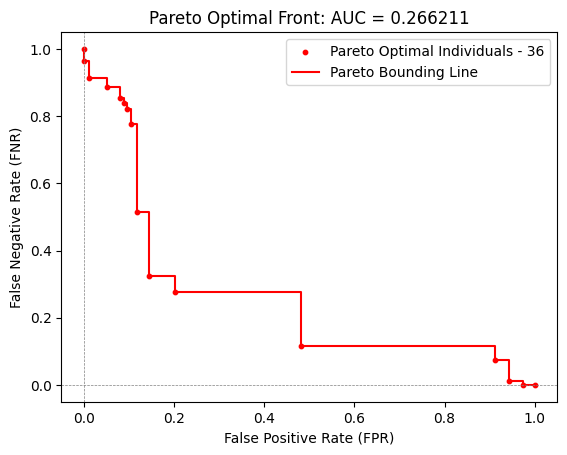

Number of Pareto-optimal individuals: 36


In [ ]:
# Extract FPR and FNR for Pareto front individuals
fpr_values = [ind.fitness.values[0] for ind in pareto_front]
fnr_values = [ind.fitness.values[1] for ind in pareto_front]

# Plot the Pareto front
# plt.scatter(fpr_values, fnr_values, c="red", label="Pareto Front")

# to do the actual visual border:
# Sort the combined list based on FNR (or FPR if needed)
combined = sorted(zip(fpr_values, fnr_values))



# =-========== CODE TO TRY TO MAKE THE GRAPH BETTER AND GRAPH ONLY STRICTLY BEST PARETO:
# Extract strictly Pareto-optimal front
pareto_front_graphed = []

current_best_fnr = float("inf")

for fpr, fnr in combined:
    if fnr < current_best_fnr:  # Ensures only strictly better FNR values are kept
        pareto_front_graphed.append((fpr, fnr))
        current_best_fnr = fnr

# Add bounding points (0,1) and (1,0)
pareto_front_graphed.insert(0, (0, 1))
pareto_front_graphed.append((1, 0))

# Unzip to separate lists
fpr_pareto, fnr_pareto = zip(*pareto_front_graphed)

# Unzip the sorted list back into separate lists (for later AUC manual calculation!)
fpr_values_sorted, fnr_values_sorted = zip(*pareto_front_graphed)

everything_but_pareto_front = list(set(combined) - set(pareto_front_graphed))
fpr_everything, fnr_everything = zip(*everything_but_pareto_front) if everything_but_pareto_front else ([], [])

# Plotting
plt.scatter(fpr_pareto, fnr_pareto, c="red", s=10, label="Pareto Optimal Individuals - %s" % (len(pareto_front)-2))
# plt.scatter(fpr_everything, fnr_everything, c="red", s=10, label="Everything Else")
plt.plot(fpr_pareto, fnr_pareto, color='red', drawstyle='steps-post', label="Pareto Bounding Line")
plt.ylabel("False Negative Rate (FNR)")
plt.xlabel("False Positive Rate (FPR)")


# Add a vertical line at x = 0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# Add a horizontal line at y = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

# AUC CALCULATION:

# Sort the combined list based on FNR (or FPR if needed)
combined_p = list(zip(fpr_pareto, fnr_pareto))
combined_p.sort()

# Unzip the sorted list back into separate lists
fpr_values_sorted, fnr_values_sorted = zip(*combined_p)




"""Calculate area under curve with least squares method"""
AUC = np.sum(np.diff(fpr_values_sorted)*fnr_values_sorted[:-1])
plt.title(f"Pareto Optimal Front: AUC = {AUC:.6f}")


plt.legend()
plt.show()

print(f"Number of Pareto-optimal individuals: {len(pareto_front)-2}")

# =================================================







# # Unzip the sorted list back into separate lists
# fpr_values_sorted, fnr_values_sorted = zip(*combined)

# plt.plot(fpr_values_sorted, fnr_values_sorted, color='r', drawstyle='steps-post')
# plt.ylabel("False Negative Rate (FNR)")
# plt.xlabel("False Positive Rate (FPR)")


# """Calculate area under curve with least squares method"""

# AUC = np.sum(np.diff(fpr_values_sorted)*fnr_values_sorted[:-1])
# plt.title("Pareto Optimal Front: AUC = %s" % AUC)

# plt.legend()
# plt.show()


In [ ]:
# Generate, using the best pareto individual, predictions on my VALIDATION SET.
best_pareto_individual = pareto_front[0]
best_func = toolbox.compile(expr=best_pareto_individual)
predictions_VAL = np.array([best_func(*x) for x in X_val])
predictions_VAL = (predictions_VAL > 0).astype(int)
predictions_VAL

# best_pareto_individual

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1])

In [ ]:
# accuracy score based on MOGP's predictions on the VALIDATION SET.
accuracy = accuracy_score(y_val, predictions_VAL)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7821229050279329


In [ ]:
# FINAL STEP: Output predictions based on TEST.CSV.
predictions_TEST = np.array([best_func(*x) for x in test_data])
predictions_TEST = (predictions_TEST > 0).astype(int)
# binary classification as final output relies on either YES or NO SURVIVAL.
predictions_TEST

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# Initialize an empty list to store predictions for each Pareto individual
predictions_all = []

# Loop through each Pareto individual
for pareto_individual in pareto_front:
    best_func = toolbox.compile(expr=pareto_individual)
    predictions = np.array([best_func(*x) for x in test_data])
    predictions = (predictions > 0).astype(int)
    predictions_all.append(predictions)

# Convert the list of predictions to a numpy array
predictions_all = np.column_stack(predictions_all)

# Convert predictions_all to a pandas DataFrame for easy manipulation and viewing
import pandas as pd
predictions_df = pd.DataFrame(predictions_all, columns=[f'Pareto_{i+1}' for i in range(predictions_all.shape[1])])

# Display the DataFrame containing predictions for ALL Pareto individuals
print(predictions_df)

     Pareto_1  Pareto_2  Pareto_3  Pareto_4  Pareto_5  Pareto_6  Pareto_7  \
0           0         0         0         1         1         0         0   
1           1         1         0         1         0         1         0   
2           0         1         1         1         0         0         0   
3           0         0         0         1         0         0         0   
4           1         1         0         1         0         1         0   
..        ...       ...       ...       ...       ...       ...       ...   
413         0         0         0         1         0         0         0   
414         1         1         1         1         1         1         0   
415         0         0         0         1         0         0         1   
416         0         0         0         1         0         0         0   
417         0         0         0         1         1         0         0   

     Pareto_8  Pareto_9  Pareto_10  ...  Pareto_26  Pareto_27  Pareto_28  \

In [ ]:
# EXPORT PREDICTIONS_TEST TO CSV.
# output_df = pd.DataFrame(predictions_df, columns=["Survived"])
predictions_df.to_csv("predictions.csv", index=False)













DONE.







_______

_

In [ ]:
# Fitness function
def fitness(individual, X, y):
  # overall comparison of evaluated X vs actual Y.
    predictions = np.array([evaluate_individual(individual, x) for x in X])
    predictions = (predictions > 0).astype(int)
    return np.mean(predictions == y)

# Genetic operations: MUTATE AND CROSSOVER ARE THE ONES WE LEARNED
# def mutate(individual, max_depth):
#     if random.random() < 0.1:
#         return generate_individual(max_depth)
#     else:
#         if isinstance(individual, list):
#             return [individual[0], mutate(individual[1], max_depth), mutate(individual[2], max_depth)]
#         else:
#             return individual
def mutate(individual, max_depth, mutation_rate=0.1):
    if random.random() < mutation_rate:
        # Replace the individual with a new random individual
        return generate_individual(max_depth)
    else:
        if isinstance(individual, list):
            # Determine if the tree is binary or unary
            is_binary = len(individual) == 3  # Binary trees have 3 elements: [func, arg1, arg2]

            if is_binary:
                # Mutate both arguments for binary trees
                return [individual[0], mutate(individual[1], max_depth, mutation_rate), mutate(individual[2], max_depth, mutation_rate)]
            else:
                # Mutate the single argument for unary trees
                return [individual[0], mutate(individual[1], max_depth, mutation_rate)]
        else:
            # If it's a terminal, return it unchanged
            return individual

def crossover(ind1, ind2):
  #THIS IS FOR ONLY UNARY OPERATORS: I NEED TO HANDLE BOTH OEN AND TWO ARGUMENTS.
    if isinstance(ind1, list) and isinstance(ind2, list):
        # swaps off indices at random timings (see the else loop)
        # Determine if the trees are binary or unary
        is_ind1_binary = len(ind1) == 3  # Binary trees have 3 elements: [func, arg1, arg2]
        is_ind2_binary = len(ind2) == 3

        if is_ind1_binary and is_ind2_binary:
            # Both trees are binary: perform standard crossover
            return [ind1[0], crossover(ind1[1], ind2[2]), crossover(ind1[2], ind2[1])]
        elif is_ind1_binary and not is_ind2_binary:
            # ind1 is binary, ind2 is unary: swap one argument
            return [ind1[0], crossover(ind1[1], ind2[1]), ind1[2]]
        elif not is_ind1_binary and is_ind2_binary:
            # ind1 is unary, ind2 is binary: swap one argument
            return [ind1[0], crossover(ind1[1], ind2[1])]
        else:
            # Both trees are unary: swap arguments
            return [ind1[0], crossover(ind1[1], ind2[1])]
        # return [ind1[0], crossover(ind1[1], ind2[2]), crossover(ind1[2], ind2[1])]
    else:
        return ind1 if random.random() < 0.5 else ind2


In [ ]:
# the actual GP programming function
def genetic_programming(pop_size, max_depth, generations, X_train, y_train):
    population = [generate_individual(max_depth) for _ in range(pop_size)]

    for gen in range(generations):
        fitness_scores = [fitness(ind, X_train, y_train) for ind in population]
        best_ind = population[np.argmax(fitness_scores)]
        print(f"Generation {gen}, Best Fitness: {max(fitness_scores)}")

        new_population = [best_ind]

        while len(new_population) < pop_size:
            parent1 = random.choice(population)
            parent2 = random.choice(population)
            child = crossover(parent1, parent2)
            child = mutate(child, max_depth)
            new_population.append(child)

        population = new_population

    return population[np.argmax(fitness_scores)]


In [ ]:
# run it
best_individual = genetic_programming(pop_size=100, max_depth=10, generations=15, X_train=X_train, y_train=y_train)

NameError: name 'generate_individual' is not defined

In [ ]:
# predictions on Test data!!
test_pred = np.array([evaluate_individual(best_individual, x) for x in test_data])
test_pred = (test_pred > 0).astype(int)
test_pred

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# save the results to a csv.
test_data["Survived"] = test_pred
# test_data[["PassengerId", "Survived"]].to_csv("submission.csv", index=False)

EVERYTHING BELOW THIS IS FROM THE ML MODEL, IGNORE (here for reference only)







---









In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# FOR PARETO GRAPH THINGY
def find_pareto(data):
  is_pareto = np.ones(data.shape[0], dtype=bool)
  for i, c in enumerate(data):
    # keep any point with a LOWER cost.
    if is_pareto[i]:
      # change for minimization

      # actual mini
      is_pareto[is_pareto] = np.any(data[is_pareto] < c, axis=1)  # Keep any point with a lower cost
      # if maximizing:
      # is_pareto[is_pareto] = np.any(data[is_pareto]>c, axis=1)
      is_pareto[i] = True  # And keep self

  pareto_data = data[is_pareto, :]

  # sort data
  pareto_out = pareto_data[np.argsort(pareto_data[:,0])]

  return pareto_out

In [ ]:
# AUC CALCULATION.
N = 20
myData = np.random.random((N,2))

myData = np.vstack(([[0,1], [1,0]], myData))

myPareto = find_pareto(myData)

# AUC under curve as riemann sum
auc = np.sum(np.diff(myPareto[:,0])*myPareto[0:-1, 1])

# figure
plt.figure()

plt.rcParams.update({'font.size': 16})

plt.scatter(myData[:,0], myData[:,1],)

# plot pareto steps.
plt.step(myPareto[:,0], myPareto[:,1], where="post")

plt.title("EX of MIN w/ AUC = " + str(auc))

plt.xlabel("false negative")
plt.ylabel("false positive")

plt.show()

# if 0, and 1
if predict 1 and actually 0 it is false

In [ ]:
myData

In [ ]:
random.seed(100)
np.random.seed(100)
## I DECIDED TO KEEP CABIN, SO THAT IS NO LONGER IN THESE DROP COMMANDS!
train_data.drop(columns=['Name', 'Ticket', "Cabin"], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket', "Cabin"], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}} # look into this; implicit issues
# Adding below line to surpress deprication warnings
pd.set_option('future.no_silent_downcasting', True)
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)


In [ ]:
print(X_train.head())
print(y_train.head())
print(test_data.head())
print(f"Test Mean: {y_test.mean()}")
print(f"Train Mean: {y_train.mean()}")

In [ ]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

In [ ]:
train_data.head()
# after all preprocessing, what does it look like?
# train_data["Parch"].unique()

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

# Initialize base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, random_state=42)

# Train models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
svc.fit(X_train, y_train)

In [ ]:
# Generate cross-validated predictions
rf_preds = cross_val_predict(rf, X_train, y_train, cv=5, method='predict_proba')[:, 1]
gb_preds = cross_val_predict(gb, X_train, y_train, cv=5, method='predict_proba')[:, 1]
svc_preds = cross_val_predict(svc, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Stack predictions into a new dataset
import numpy as np
meta_features = np.column_stack((rf_preds, gb_preds, svc_preds))


In [ ]:
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(meta_features, y_train)

In [ ]:
# Generate predictions from base models on X_test
rf_test_preds = rf.predict_proba(X_test)[:, 1]
gb_test_preds = gb.predict_proba(X_test)[:, 1]
svc_test_preds = svc.predict_proba(X_test)[:, 1]

# Stack test set predictions
meta_test_features = np.column_stack((rf_test_preds, gb_test_preds, svc_test_preds))

# Final prediction
final_predictions = meta_model.predict(meta_test_features)

In [ ]:
# svm_clf.fit(X_train.values, y_train.values)
# print(svm_clf.score(X_test.values, y_test.values))

final_predictions

In [ ]:
matches = final_predictions == y_test.values
print(f"Accuracy: {matches.sum()/len(matches)}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


# Define hyperparameter grid for RandomForest
rf_params = {
    "n_estimators": randint(50, 200),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10),
}

# Randomized search
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Use best parameters
best_rf = rf_search.best_estimator_
print("Best Random Forest:", rf_search.best_params_)

In [ ]:
best_rf.fit(X_train, y_train)
best_rf.score(X_test, y_test)

In [ ]:
y_pred = best_rf.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_truth = y_test.values


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
predictions = best_rf.predict(test_data.values)
predictions

In [ ]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)
pred_df

In [ ]:
pred_df.to_csv('predictions.csv', header=True, sep=',')

EVERYTHING ELSE BELOW THIS WAS TESTING:

In [ ]:
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression(max_iter=1000, random_state=42)
# logreg.fit(X_train, y_train)

# y_pred = logreg.predict(X_test)
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# # print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# # DEcision Tree Classifier?
# from sklearn.tree import DecisionTreeClassifier
# dtree = DecisionTreeClassifier(random_state=42)
# dtree.fit(X_train, y_train)

In [ ]:
# score it again:
y_pred = dtree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
#Try a randomForestClassifier:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=100, random_state=42)
rforest.fit(X_train, y_train)
rforest.score(X_test, y_test)

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dtree.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

In [ ]:
# choose best option:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rforest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

In [ ]:
best_model.score(X_test, y_test)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Identify categorical columns
# categorical_cols = ['Sex', 'Embarked']

# # Apply OneHotEncoder
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
# X_test_encoded = encoder.transform(X_test[categorical_cols])
# test_data_encoded = encoder.transform(test_data[categorical_cols])

# # Convert to DataFrame
# import pandas as pd
# X_train_encoded = pd.DataFrame(X_train_encoded, index=X_train.index)
# X_test_encoded = pd.DataFrame(X_test_encoded, index=X_test.index)
# test_data_encoded = pd.DataFrame(test_data_encoded, index=test_data.index)

# # Drop original categorical columns and concatenate new encoded ones
# X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
# X_test = X_test.drop(columns=categorical_cols).reset_index(drop=True)
# test_data = test_data.drop(columns=categorical_cols).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)
test_data = pd.concat([test_data, test_data_encoded], axis=1)

In [ ]:
y_train
# y_train.shape

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
y_train = y_train.values.ravel()

In [ ]:
import xgboost
import sklearn

print(f"XGBoost version: {xgboost.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

In [ ]:
!pip install --upgrade xgboost scikit-learn


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [ ]:
# check for the missing ages:
ratio = np.round(train_data.Age.isna().sum()/len(train_data.index)*100, decimals=1)
print('The percentage of missing ages is ', ratio,'%')
train_data.Age.isna().sum()
# train_data.count(1)
train_data.Age[train_data.Age.isna()] = train_data.Age.mean() # replace non-ages with the average (HUGE assumption but better than having no age at all)

In [ ]:
sns.countplot(data=train_data,x='SibSp',hue="Survived")
train_data.SibSp.value_counts()

In [ ]:
# train_data.Parch.value_counts()

train_data.Parch.clip(upper=2,inplace=True)
oh= pd.get_dummies(train_data.Parch,prefix="Parch")
train_data = train_data.drop(labels='Parch',axis=1).join(oh)
# essentially clip value of parch

In [ ]:
#normalize the fare!!!!
train_data.Fare = (train_data.Fare-train_data.Fare.mean())/train_data.Fare.std()
sns.kdeplot(data=train_data,x='Fare', shade=True,hue="Survived")


In [ ]:
# Deal with Missing Cabin details:
train_data.Cabin[train_data.Cabin.isna()]="U"

In [ ]:
train_data.Cabin  = train_data.Cabin.str[0] # get the first letter
train_data.Cabin.value_counts()

In [ ]:
sns.countplot(data=train_data,x=train_data.Cabin,hue="Survived")

In [ ]:
# Chi squared test for each of the cabins:
from scipy.stats import chi2_contingency
y = train_data.Survived
for letter in train_data.Cabin.unique():
    cab_binary = train_data.Cabin==letter
    contigency = pd.crosstab(cab_binary, y)
    c, p, dof, expected = chi2_contingency(contigency)
    p = np.round(p*100,decimals=3)
    print('Chi2 test for the independence of Cabin = ',letter,'. p-value =',p,"%")

In [ ]:
# we can do one-hot encoding to make the cabins with more useful info stay while rejecting poorer p-values.
oh = pd.get_dummies(train_data.Cabin,prefix="Cabin")
categories_to_drop = ['Cabin_'+i for i in ['G','A','F','T']]
oh = oh.drop(labels = categories_to_drop, axis = 1)

train_data = train_data.drop(labels='Cabin',axis=1).join(oh)

In [ ]:
train_data.Embarked.value_counts()

In [ ]:
oh= pd.get_dummies(train_data.Embarked,prefix="Embarked")
train_data = train_data.drop(labels='Embarked',axis=1).join(oh)
# this is one hot encoding for embarked

In [ ]:
train_data.info()
train_data.corr()

In [ ]:
# mutual information score all our features, see if certain ones matter more (pca after?)
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    # discrete_features = [X.columns.get_loc(column_name) for column_name in X.dtypes[X.dtypes=='uint8'].index]
    # Modified line to include more dtypes for discrete features:
    discrete_features = X.select_dtypes(include=['number', 'bool', 'object', 'category']).columns
    # Get the column indices for discrete features:
    discrete_features = [X.columns.get_loc(col) for col in discrete_features]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


# train_data.drop(columns=['Survived'], inplace=True)
mi_scores = make_mi_scores(train_data, y)
train_data = train_data[mi_scores.index]
sns.barplot(x=mi_scores, y=mi_scores.index)

In [ ]:
from sklearn.linear_model import LogisticRegression

model_LogReg = LogisticRegression(solver='liblinear')
model_LogReg.fit(train_data, y)

coefs=pd.DataFrame({'coefficient':model_LogReg.coef_[0]}, index = train_data.columns)

coefs.sort_values('coefficient', key=abs, ascending=False,inplace=True)


sns.barplot(y=coefs.index, x=coefs['coefficient'])

print('intercept = ',model_LogReg.intercept_[0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(train_data, y, train_size=0.8, test_size=0.2,random_state=1,shuffle=True)

In [ ]:
random.seed(100)
np.random.seed(100)

tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train.values, y_train.values)
print(tree_clf.score(X_test.values, y_test.values))

In [ ]:
random.seed(100)
np.random.seed(100)

knn_clf = neighbors.KNeighborsClassifier()
knn_clf.fit(X_train.values, y_train.values)
print(knn_clf.score(X_test.values, y_test.values))

In [ ]:
random.seed(100)
np.random.seed(100)

NN_clf = neural_network.MLPClassifier()
NN_clf.fit(X_train.values, y_train.values)
print(NN_clf.score(X_test.values, y_test.values))

In [ ]:
random.seed(100)
np.random.seed(100)

svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train.values, y_train.values)
print(svm_clf.score(X_test.values, y_test.values))
y_pred = svm_clf.predict(X_test.values)
y_truth = y_test.values

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
predictions = svm_clf.predict(test_data.values)

In [ ]:
type(predictions)

In [ ]:
predictions

In [ ]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)

In [ ]:
pred_df

In [ ]:
pred_df.to_csv('predictions.csv', header=True, sep=',')